### This notebook is to obtain the data from rawg.io and pricecharts.com
### It also cleans part of the data

In [1]:
#set up the api to get gamedatabase from RAWG.com
#For more details of the python wrapper of this api, please check out laundmo's website https://pypi.org/project/rawgpy
import rawgpy as ry
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt

### One of the major source of data is from pricecharts.com. After paying for the data, a customized csv ("price-guide.csv") containing information such as prices (new-price) and genre can be downloaded. 
### Please note that the following labels need to be included for the script to work:
###### "console-name","product-name","loose-price","cib-price","new-price","gamestop-price","gamestop-trade-price","retail-loose-buy",
###### "retail-loose-sell","retail-cib-buy","retail-cib-sell","retail-new-buy","retail-new-sell"

In [2]:
#read the file from pricecharts.com
filename = "price-guide.csv"
price_data = pd.read_csv(filename,encoding = "mac_roman")
price_data.head(5)

,id,console-name,product-name,loose-price,cib-price,new-price,gamestop-price,gamestop-trade-price,retail-loose-buy,retail-loose-sell,retail-cib-buy,retail-cib-sell,retail-new-buy,retail-new-sell,sales-volume,genre,release-date
0,16491,3DO,20th Century Video Almanac,$6.40,$29.99,$49.00,NaN,NaN,$1.34,$6.69,$9.30,$30.99,$20.40,$50.99,4,Action & Adventure,1/1/1993
1,16492,3DO,3D Atlas,$11.50,$22.32,$36.94,NaN,NaN,$2.40,$11.99,$6.90,$22.99,$15.60,$38.99,5,Action & Adventure,1/1/1994
2,16493,3DO,3DO Buffet,$5.56,$9.00,$17.00,NaN,NaN,$1.16,$5.79,$1.90,$9.49,$3.60,$17.99,6,Action & Adventure,4/27/1995
3,16662,3DO,3DO Console,$110.89,$210.31,$349.50,NaN,NaN,$46.40,$115.99,$88.40,$220.99,$146.80,$366.99,67,Systems,NaN
4,40421,3DO,3DO Console FZ-10,$66.03,$145.27,$296.85,NaN,NaN,$27.60,$68.99,$61.20,$152.99,$124.80,$311.99,3,Systems,1/1/1995


In [3]:
#there are in total 49638 lines of data
len(price_data)

49638

In [5]:
#add a new column with new format of the dates
price_data["release-date-dt"] = pd.to_datetime(price_data["release-date"], errors="coerce")

In [6]:
#check the NaT on the release date
price_data[price_data["release-date-dt"].isnull()].head(5)

,id,console-name,product-name,loose-price,cib-price,new-price,gamestop-price,gamestop-trade-price,retail-loose-buy,retail-loose-sell,retail-cib-buy,retail-cib-sell,retail-new-buy,retail-new-sell,sales-volume,genre,release-date,release-date-dt
3,16662,3DO,3DO Console,$110.89,$210.31,$349.50,NaN,NaN,$46.40,$115.99,$88.40,$220.99,$146.80,$366.99,67,Systems,NaN,NaT
23,16509,3DO,C.P.U. Bach,$9.99,$12.04,$23.54,NaN,NaN,$2.00,$9.99,$2.60,$12.99,$7.50,$24.99,15,Action & Adventure,NaN,NaT
28,16514,3DO,Club 3DO: Station Invasion,$8.98,$10.23,$40.37,NaN,NaN,$1.88,$9.39,$2.20,$10.99,$16.80,$41.99,5,Action & Adventure,NaN,NaT
47,16534,3DO,Dragon's Lair,$12.72,$30.99,$58.28,NaN,NaN,$2.60,$12.99,$9.90,$32.99,$24.40,$60.99,63,Action & Adventure,NaN,NaT
60,16542,3DO,Fatty Bear's Fun Pack,$12.59,$28.43,$56.65,NaN,NaN,$2.60,$12.99,$9.00,$29.99,$23.60,$58.99,3,Action & Adventure,NaN,NaT


In [7]:
price_data["release-date-dt"].isnull().value_counts()

False    46989
True      2649
Name: release-date-dt, dtype: int64

In [8]:
#keep the error data for further analysis in the future
price_data_date_error = price_data[price_data["release-date-dt"].isnull()]

##### Data will be processed in the following way:
##### 1. Remove dollar signs on the prices
##### 2. The release year will be a separate column as an additional matching condition for other information in rawg
##### 3. Product names need to be changed to "slug" name format for searching game information on the rawg website
##### 4. We only need games--so rows with a genres "Systems", "Accessories" and "Controllers" need to be filtered out
##### 5. Missing data needs to be handled

### 1. Removing the dollar signs

In [9]:
price_titles = ["loose-price","cib-price","new-price","gamestop-price","gamestop-trade-price","retail-loose-buy",
                "retail-loose-sell","retail-cib-buy","retail-cib-sell","retail-new-buy","retail-new-sell"]

In [10]:
#replacing the dollar signs
for title in price_titles:
    price_data[title] = price_data[title].str.replace('$','')

### 2. The release year should be an additional column

In [11]:
#add one more colume with only year
price_data["release-year"] =  price_data["release-date-dt"].apply(lambda x:x.year)

### 3. Change Product-Name to Slug Name
##### After observing the slug names in RAWG, these are the obvious patterns:
##### 1. slugs are all lower cases
##### 2. all the columns (semicolumns)and spaces are replaces by "-"
##### 3. Apostrophies and dots are deleted
##### 4. One issue I see is that in some of the sequals, arab numbers are added at the end of the title (While some other sequals does not have that number).However, with good-enough slug name, the first hit from the search function of RAWG seems always comes up with the correct answer

In [12]:
#create a copy of the product names - keep the original in case we want to get back at the end
price_data["product-name-slug"] = price_data["product-name"]

In [13]:
#change all to lower cases
price_data["product-name-slug"]  =  price_data["product-name-slug"].str.lower()
#delete all the apostrophes and dots
price_data["product-name-slug"]  = price_data["product-name-slug"].str.replace("\'","")
price_data["product-name-slug"]  = price_data["product-name-slug"].str.replace(".","")

#all the columns (semicolumns)and spaces are replaces by "-"
price_data["product-name-slug"]  = price_data["product-name-slug"].str.replace(":","-")
price_data["product-name-slug"]  = price_data["product-name-slug"].str.replace(";","-")
price_data["product-name-slug"]  = price_data["product-name-slug"].str.replace(" ","-")

###### Examine the data in detail

In [14]:
price_data["genre"].unique()

array(['Action & Adventure', 'Systems', 'Controllers', 'Other', 'FPS',
       'Baseball', 'Sports', 'Soccer', 'Accessories', 'Puzzle', 'Racing',
       'Strategy', 'Visual Novel', 'Arcade', 'Fighting', "Shoot'em Up",
       'Platformer', 'Football', 'Educational', 'Basketball', 'RPG',
       'Wrestling', 'Extreme Sports', 'Sport', 'Music', 'Simulation',
       'Party', 'Extreme', 'Skateboarding', 'Dance', 'Fishing',
       'Magazine', 'Hockey', "Racing'", 'Racomg', 'Action', 'FIghting',
       'Golf', 'Space Combat Sim', 'RTT', 'Trivia', "Shoot 'em Up",
       'Game show', 'Stealth', 'Fitness', 'Controller'], dtype=object)

 it is clear that genres with "Systems", "Controllers", "Controller", "Magazine" and "Accessories" are not actually video games

In [15]:
#example
price_data[price_data["genre"]=='Systems'].head(5)

,id,console-name,product-name,loose-price,cib-price,new-price,gamestop-price,gamestop-trade-price,retail-loose-buy,retail-loose-sell,retail-cib-buy,retail-cib-sell,retail-new-buy,retail-new-sell,sales-volume,genre,release-date,release-date-dt,release-year,product-name-slug
3,16662,3DO,3DO Console,110.89,210.31,349.50,NaN,NaN,46.40,115.99,88.40,220.99,146.80,366.99,67,Systems,NaN,NaT,NaN,3do-console
4,40421,3DO,3DO Console FZ-10,66.03,145.27,296.85,NaN,NaN,27.60,68.99,61.20,152.99,124.80,311.99,3,Systems,1/1/1995,1995-01-01,1995.0,3do-console-fz-10
5,40422,3DO,3DO Console Goldstar,119.54,223.13,446.26,NaN,NaN,50.40,125.99,93.60,233.99,187.60,468.99,29,Systems,1/1/1995,1995-01-01,1995.0,3do-console-goldstar
6,40424,3DO,3DO Console Robo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Systems,1/1/1995,1995-01-01,1995.0,3do-console-robo
7,40423,3DO,3DO Console Sanyo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Systems,1/1/1995,1995-01-01,1995.0,3do-console-sanyo


In [16]:
price_data[price_data["genre"]== 'Controllers'].head(5)

,id,console-name,product-name,loose-price,cib-price,new-price,gamestop-price,gamestop-trade-price,retail-loose-buy,retail-loose-sell,retail-cib-buy,retail-cib-sell,retail-new-buy,retail-new-sell,sales-volume,genre,release-date,release-date-dt,release-year,product-name-slug
8,40414,3DO,3DO Controller,19.48,44.01,87.84,NaN,NaN,4.00,19.99,18.40,45.99,36.80,91.99,4,Controllers,1/1/1995,1995-01-01,1995.0,3do-controller
9,59649,3DO,3DO Gamegun,110.00,242.00,495.00,NaN,NaN,46.40,115.99,101.60,253.99,208.00,519.99,3,Controllers,1/1/1993,1993-01-01,1993.0,3do-gamegun
426,40412,Atari 2600,Atari 2600 Controller,9.96,26.89,40.33,NaN,NaN,2.00,9.99,8.40,27.99,16.80,41.99,4,Controllers,1/1/1980,1980-01-01,1980.0,atari-2600-controller
428,40413,Atari 2600,Atari 2600 Paddle Controller Set,16.98,52.29,78.44,NaN,NaN,3.60,17.99,22.00,54.99,32.80,81.99,425,Controllers,1/1/1980,1980-01-01,1980.0,atari-2600-paddle-controller-set
522,38583,Atari 2600,Comsmic Commander Control,49.89,133.00,199.50,NaN,NaN,20.80,51.99,56.00,139.99,83.60,208.99,3,Controllers,1/1/1985,1985-01-01,1985.0,comsmic-commander-control


In [17]:
price_data[price_data["genre"]== 'Controller'].head(5)

,id,console-name,product-name,loose-price,cib-price,new-price,gamestop-price,gamestop-trade-price,retail-loose-buy,retail-loose-sell,retail-cib-buy,retail-cib-sell,retail-new-buy,retail-new-sell,sales-volume,genre,release-date,release-date-dt,release-year,product-name-slug
45481,38579,Wii,Tatsunoko vs. Capcom: Ultimate All Stars Contr...,34.17,51.26,102.51,NaN,NaN,14.40,35.99,21.60,53.99,43.20,107.99,4,Controller,1/26/2010,2010-01-26,2010.0,tatsunoko-vs-capcom--ultimate-all-stars-contro...


In [18]:
price_data[price_data["genre"]== 'Magazine'].head(5)

,id,console-name,product-name,loose-price,cib-price,new-price,gamestop-price,gamestop-trade-price,retail-loose-buy,retail-loose-sell,retail-cib-buy,retail-cib-sell,retail-new-buy,retail-new-sell,sales-volume,genre,release-date,release-date-dt,release-year,product-name-slug
13880,54135,Nintendo Power,[Volume 100] 100 Best Games Issue,16.88,NaN,NaN,NaN,NaN,3.60,17.99,6.60,21.99,NaN,NaN,49,Magazine,9/1/1997,1997-09-01,1997.0,[volume-100]-100-best-games-issue
13881,54327,Nintendo Power,[Volume 101] Extreme G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Magazine,1/1/1997,1997-01-01,1997.0,[volume-101]-extreme-g
13882,54133,Nintendo Power,[Volume 102] NFL Quarterback Club,7.14,NaN,NaN,NaN,NaN,1.50,7.49,2.00,9.99,NaN,NaN,18,Magazine,11/1/1997,1997-11-01,1997.0,[volume-102]-nfl-quarterback-club
13883,54138,Nintendo Power,[Volume 103] Diddy Kong's Racing,8.50,NaN,NaN,NaN,NaN,1.78,8.89,2.20,10.99,NaN,NaN,16,Magazine,12/1/1997,1997-12-01,1997.0,[volume-103]-diddy-kongs-racing
13884,54146,Nintendo Power,[Volume 104] Yoshi's Story,10.50,NaN,NaN,NaN,NaN,2.20,10.99,2.80,13.99,NaN,NaN,14,Magazine,1/1/1998,1998-01-01,1998.0,[volume-104]-yoshis-story


In [19]:
price_data[price_data["genre"]== 'Accessories'].head(5)

,id,console-name,product-name,loose-price,cib-price,new-price,gamestop-price,gamestop-trade-price,retail-loose-buy,retail-loose-sell,retail-cib-buy,retail-cib-sell,retail-new-buy,retail-new-sell,sales-volume,genre,release-date,release-date-dt,release-year,product-name-slug
66,46398,3DO,GameGun,43.38,145.00,290.00,NaN,NaN,18.40,45.99,60.80,151.99,122.00,304.99,6,Accessories,1/1/1995,1995-01-01,1995.0,gamegun
214,58194,Amiibo,Daisy [Super Smash Bros],18.50,NaN,20.20,NaN,NaN,3.80,18.99,6.90,22.99,6.30,20.99,121,Accessories,4/12/2019,2019-04-12,2019.0,daisy-[super-smash-bros]
234,55698,Amiibo,Ice Climbers,14.00,NaN,16.66,NaN,NaN,3.00,14.99,3.60,17.99,3.40,16.99,248,Accessories,2/15/2019,2019-02-15,2019.0,ice-climbers
246,62454,Amiibo,Isabelle,6.99,NaN,25.03,NaN,NaN,1.46,7.29,1.80,8.99,7.80,25.99,473,Accessories,7/26/2019,2019-07-26,2019.0,isabelle
249,63780,Amiibo,Ivysaur,14.04,NaN,14.99,NaN,NaN,3.00,14.99,3.60,17.99,3.20,15.99,3,Accessories,9/20/2019,2019-09-20,2019.0,ivysaur


### 4. Genres such as "systems" need to be removed to have a clean view on "games" only

In [20]:
genre_to_delete = ['Systems','Magazine','Controllers','Controller','Accessories']

In [21]:
#before modification
len(price_data)

49638

In [22]:
#drop these lines
for g_ko in genre_to_delete:
    price_data = price_data.drop(price_data[price_data['genre'] == g_ko].index)

In [23]:
#after deletion
len(price_data)

48105

### 5. Handling Missing Data on "release-year"

In [24]:
price_data_date_error.head(5)

,id,console-name,product-name,loose-price,cib-price,new-price,gamestop-price,gamestop-trade-price,retail-loose-buy,retail-loose-sell,retail-cib-buy,retail-cib-sell,retail-new-buy,retail-new-sell,sales-volume,genre,release-date,release-date-dt
3,16662,3DO,3DO Console,$110.89,$210.31,$349.50,NaN,NaN,$46.40,$115.99,$88.40,$220.99,$146.80,$366.99,67,Systems,NaN,NaT
23,16509,3DO,C.P.U. Bach,$9.99,$12.04,$23.54,NaN,NaN,$2.00,$9.99,$2.60,$12.99,$7.50,$24.99,15,Action & Adventure,NaN,NaT
28,16514,3DO,Club 3DO: Station Invasion,$8.98,$10.23,$40.37,NaN,NaN,$1.88,$9.39,$2.20,$10.99,$16.80,$41.99,5,Action & Adventure,NaN,NaT
47,16534,3DO,Dragon's Lair,$12.72,$30.99,$58.28,NaN,NaN,$2.60,$12.99,$9.90,$32.99,$24.40,$60.99,63,Action & Adventure,NaN,NaT
60,16542,3DO,Fatty Bear's Fun Pack,$12.59,$28.43,$56.65,NaN,NaN,$2.60,$12.99,$9.00,$29.99,$23.60,$58.99,3,Action & Adventure,NaN,NaT


In [25]:
price_data_date_error["genre"].value_counts()

Action & Adventure    1663
Accessories            155
Other                  154
Systems                 93
Sports                  75
Racing                  68
Arcade                  56
Controllers             52
Puzzle                  47
Shoot'em Up             39
Fighting                34
RPG                     32
Platformer              30
Simulation              30
FPS                     20
Strategy                17
Party                   16
Basketball              11
Football                11
Baseball                10
Soccer                   9
Music                    8
Wrestling                6
Extreme Sports           5
Dance                    4
Educational              2
Visual Novel             2
Name: genre, dtype: int64

 It is worth pointing out that many titles with such error are real games 
 
 
 let's look at some example

In [29]:
#missing release year example: Assassin\'s Creed IV: Black Flag
df_assassin = price_data[price_data['product-name'].str.match('Assassin\'s Creed IV: Black Flag')]
df_assassin["release-year"].isnull().value_counts()

False    14
True      1
Name: release-year, dtype: int64

In [30]:
#another example: BioShock
df_bioshock = price_data[price_data['product-name'].str.match('BioShock ')]
df_bioshock["release-year"].isnull().value_counts()

False    24
True      1
Name: release-year, dtype: int64

In [31]:
# third example Yoku's Island Express
df_YokuIsland = price_data[price_data['product-name'].str.match('Yoku\'s Island')]
df_YokuIsland["release-year"].isnull().value_counts()

False    4
True     1
Name: release-year, dtype: int64

In [32]:
#example:Dragon's Lair
df_DragonLair = price_data[price_data['product-name'].str.match('Dragon\'s Lair')]
df_DragonLair["release-year"].isnull().value_counts()

False    25
True      5
Name: release-year, dtype: int64

It seems that games with a missing release data/year is usually available on other platforms and the error could be due to user inputs. I have also noticed that release dates are not exact (which could be explained by the fact that the information is based on the sales record of second-hand games), although the release year is fairly accurate. In any case, it is important to check whether the data are missing randomly.

### Check if the missing data are random with respect to the complete data

In [33]:
#number of mising prices in the data set
len(price_data_date_error[price_data_date_error["new-price"].isnull()])

531

In [34]:
#filter out the wrong genres (No concoles, accessories, etc)
for g_ko in genre_to_delete:
    price_data_date_error= price_data_date_error.drop(price_data_date_error[price_data_date_error['genre'] == g_ko].index)   

In [35]:
#let's check the distribution of sales-volume and new price in the dataset with missing release year
sales_v_error = price_data_date_error["sales-volume"]

In [36]:
np.max(sales_v_error ) 

15831

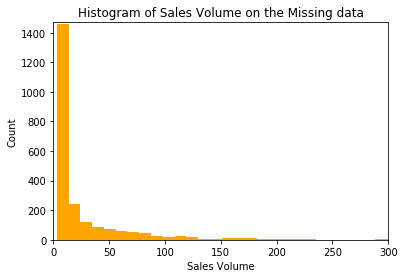

In [37]:
#draw histogram
%matplotlib inline
# matplotlib histogram
n, bins, patches = plt.hist(sales_v_error, color = 'orange',
         bins = 1500)

# Add labels
plt.title('Histogram of Sales Volume on the Missing data')
plt.xlabel('Sales Volume')
plt.ylabel('Count')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(0,300)
plt.show()

In [38]:
rows_prices_v_error = price_data_date_error[price_data_date_error["new-price"].notnull()]
prices_v_error = rows_prices_v_error["new-price"].str.replace("$","")
prices_v_error = prices_v_error.str.replace(",","")

In [39]:
prices_v_error = prices_v_error.astype(float)

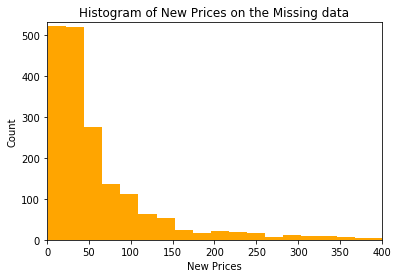

In [40]:
#draw histogram of the prices on the missing data
%matplotlib inline
# matplotlib histogram
n, bins, patches = plt.hist(prices_v_error, color = 'orange',
         bins = 1500)

# Add labels
plt.title('Histogram of New Prices on the Missing data')
plt.xlabel('New Prices')
plt.ylabel('Count')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(0,400)
plt.show()

By first look, it seems that the missing data is concentrated on the low-priced games, which might not random. However,the same pattern exists in the instances without missing "release-year":

In [41]:
#sales volume & sales price for new titles
sales_v = price_data["sales-volume"]
rows_prices_v= price_data[price_data["new-price"].notnull()]
prices_v = rows_prices_v["new-price"].str.replace("$","")
prices_v= prices_v.str.replace(",","")
prices_v = prices_v.astype(float)

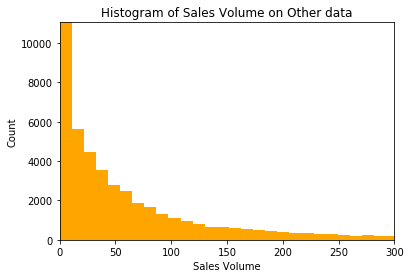

In [45]:
#draw sales volume
%matplotlib inline
# matplotlib histogram
n, bins, patches = plt.hist(sales_v, color = 'orange',
         bins = 1500)

# Add labels
plt.title('Histogram of Sales Volume on Other data')
plt.xlabel('Sales Volume')
plt.ylabel('Count')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(0,300)
plt.show()

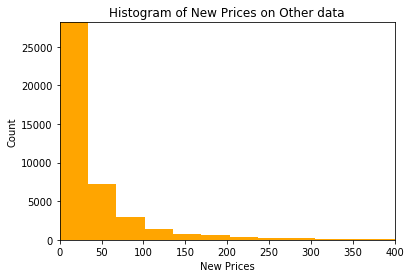

In [44]:
#draw histogram of the prices on the complete data
%matplotlib inline
# matplotlib histogram
n, bins, patches = plt.hist(prices_v, color = 'orange',
         bins = 1500)

# Add labels
plt.title('Histogram of New Prices on Other data')
plt.xlabel('New Prices')
plt.ylabel('Count')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(0,400)
plt.show()

As one can see, the prices and sale data exibit the same trend between the set with missing date and the set without missing date,signaling that the missing data is very likely random. We will delete these rows as a result. We will work with the modified dataframe price_data moving forward.

In [47]:
#we need to also check missing prices
#check length of missing data
price_data_price_error = price_data[price_data["new-price"].isnull()]
print("The proportion of missing release year (NaT) is: ", len(price_data_price_error)/len(price_data))

The proportion of missing release year (NaT) is:  0.10553996466063818


In [48]:
#check if the missing prices are random by looking at sales volumes 
#(so that the missing data has the same pattern as the non-missing data ones)
sales_data_price_nok = price_data.loc[price_data["new-price"].isnull(),"sales-volume"]
sales_data_price_ok = price_data.loc[price_data["new-price"].notnull(),"sales-volume"]

In [49]:
len(sales_data_price_ok)

43028

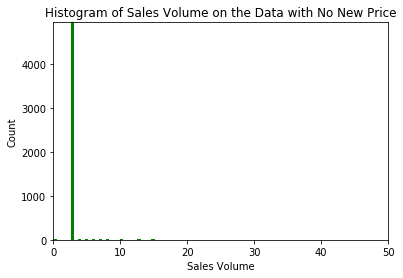

In [50]:
#plot to see

#draw sales volume
%matplotlib inline
# matplotlib histogram
n, bins, patches = plt.hist(sales_data_price_nok, color = 'green',
         bins = 800)

# Add labels
plt.title('Histogram of Sales Volume on the Data with No New Price')
plt.xlabel('Sales Volume')
plt.ylabel('Count')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(0,50)
plt.show()

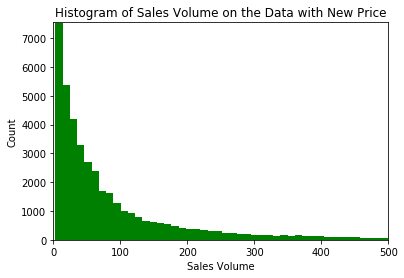

In [51]:
%matplotlib inline
# matplotlib histogram
n, bins, patches = plt.hist(sales_data_price_ok, color = 'green',
         bins = 1500)

# Add labels
plt.title('Histogram of Sales Volume on the Data with New Price')
plt.xlabel('Sales Volume')
plt.ylabel('Count')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(0,500)
plt.show()

In general, the pattern of sales volume of the ones with missing data follow the same trend as ones of the non-missing data. However, the case is much more extreme than the instances with missing dates. It seems that "penny" games are especially effected. For now, we proceed with filtering out these games but it might be worthwhile to come back for this later.

In [52]:
label_lst = ["id","console-name","product-name","new-price","loose-price","sales-volume", 
             "genre","release-date","release-date-dt","release-year","product-name-slug"]

In [53]:
#delete the rows with missing prices and missing release dates
price_data_to_use = price_data.loc[price_data["new-price"].notnull(),label_lst]
price_data_to_use = price_data_to_use.loc[price_data["release-year"].notnull(),label_lst]

In [54]:
price_data_to_use.head(5)

,id,console-name,product-name,new-price,loose-price,sales-volume,genre,release-date,release-date-dt,release-year,product-name-slug
0,16491,3DO,20th Century Video Almanac,49.00,6.40,4,Action & Adventure,1/1/1993,1993-01-01,1993.0,20th-century-video-almanac
1,16492,3DO,3D Atlas,36.94,11.50,5,Action & Adventure,1/1/1994,1994-01-01,1994.0,3d-atlas
2,16493,3DO,3DO Buffet,17.00,5.56,6,Action & Adventure,4/27/1995,1995-04-27,1995.0,3do-buffet
10,35962,3DO,3DO Maniac Pack,269.99,41.58,7,Other,1/1/1995,1995-01-01,1995.0,3do-maniac-pack
11,16496,3DO,Alone in the Dark,50.00,12.44,52,Action & Adventure,1/1/1993,1993-01-01,1993.0,alone-in-the-dark


##### Next step is to merge several columns of data:
##### 1. Combine rows with the same title and release year in price_data by taking the weighted average of the new prices. Note that versions with additional features (games with additional features such as DLC and add-ons that were released the same year) will be considered a seperated game.
##### 2. Sales Volume will be summed up during merge.

In [55]:
#change new-price to float
price_data_to_use["new-price"] = price_data_to_use["new-price"].str.replace(",","")
price_data_to_use["new-price"] = price_data_to_use["new-price"].astype(float)

In [56]:
#modification 10/28 same applies to loose price
price_data_to_use["loose-price"] = price_data_to_use["loose-price"].str.replace(",","")
price_data_to_use["loose-price"] = price_data_to_use["loose-price"].astype(float)

In [57]:
type(price_data_to_use.loc[0,"new-price"] )

numpy.float64

In [58]:
loose_p = price_data_to_use.loc[:,"loose-price"]

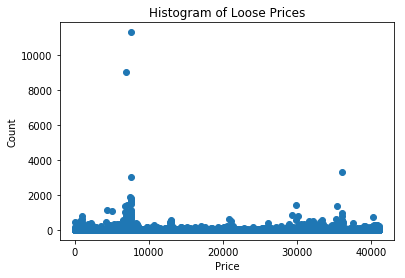

In [59]:
#explore the loose price (open-box prices)
%matplotlib inline
# matplotlib histogram
plt.scatter(range(len(loose_p)),loose_p)

# Add labels
plt.title('Histogram of Loose Prices')
plt.xlabel('Price')
plt.ylabel('Count')

plt.show()

In [60]:
#examine outliers
price_data_to_use.loc[price_data_to_use["loose-price"]>500].head(5)


,id,console-name,product-name,new-price,loose-price,sales-volume,genre,release-date,release-date-dt,release-year,product-name-slug
1189,33593,Atari 400,Softporn Adventure,2757.03,613.31,4,Action & Adventure,1/1/1981,1981-01-01,1981.0,softporn-adventure
1222,33500,Atari 400,Ultima I: The Original,3643.11,810.00,3,RPG,1/1/1980,1980-01-01,1980.0,ultima-i--the-original
5902,34078,GameBoy Color,Zelda Oracle of Ages & Seasons Limited Edition,3971.39,1134.88,3,Action & Adventure,5/21/2001,2001-05-21,2001.0,zelda-oracle-of-ages-&-seasons-limited-edition
6624,33018,Intellivision,Spiker! Super Pro Volleyball,1800.00,1055.22,6,Sports,1/1/1989,1989-01-01,1989.0,spiker!-super-pro-volleyball
9607,35787,Jaguar,BattleSphere,2628.14,584.01,9,Simulation,2/1/2000,2000-02-01,2000.0,battlesphere


#### Note that some games have prices out of the chart due to their values for collectors

In [61]:
#group by product-name-slug, to get the release-year of max(sales-volume), total sales-volume, 
#and the weighted average of new-price

#weighted mean
wm = lambda x: np.average(x, weights=price_data_to_use.loc[x.index, "new-price"])

#function to get the release year of max sales volume
max_ry = lambda x:  price_data_to_use.loc[price_data_to_use.loc[x.index,"sales-volume"].idxmax(),"release-year"]

#a directory for the functions to apply
f = {"new-price":wm,"sales-volume":['sum'],"release-year":max_ry}

grouped_price_data = price_data_to_use.groupby(['product-name-slug']).agg(f)


In [62]:
len(grouped_price_data["release-year"].isnull() == True)

22923

In [63]:
grouped_price_data.head(5)

,new-price,sales-volume,release-year
,<lambda>,sum,<lambda>
product-name-slug,,,
-30-great-games--family-party,7.880000,16,2008.0
007--agent-under-fire,12.430000,97,2002.0
007--everything-or-nothing,9.987067,143,2004.0
007--from-russia-with-love,8.940000,99,2005.0
007--nightfire,38.152903,255,2003.0


### Search other game information from rawg
##### Next step is to search the rawg database using the slug name to include features such as genres, developers, rating, platforms, release years, and description
##### To search, we first try searching accurately by slug and release year, if no match then try rough seach by slug and release year. If successful, we will store the first result, if not we will proceed by dumping that data point

In [64]:
#initialize the api
rawg = ry.RAWG("")

In [65]:
grouped_price_data_test = grouped_price_data

In [66]:
#create columns to hold features
label_features = ["genres","name","slug","rating","developers","platforms","tags","match"]

In [67]:
def add_label(label_lst,rawg_item,index,df):
    for label in label_lst:
        v =  getattr(rawg_item,label)
        if (label == "platforms"):
            #need console names
            if len(v) == 1:
                df.at[index,label] = [p.name for p in v]
            elif len(v) >1:
                df.at[index,label] = ",".join(p.name for p in v)                    
        else:
            if isinstance(v,str):
                df.at[index,label] = v
            elif isinstance(v,float):
                df.at[index,label] = v
            #else if it's a list
            elif len(v) == 1:
                df.at[index,label] = str(v)
            elif len(v)>1:
                df.at[index,label] = ",".join(str(vv) for vv in v)
    
    return df

In [68]:
grouped_price_data_copy = grouped_price_data.copy()
for title in label_features:
    grouped_price_data_copy[title] = np.nan

In [294]:
#please note that this part of the code can take a while
#this is to get other information from rawg website through api, if the game name and its release year are matching
count = 0
for index,row in grouped_price_data_copy.iterrows():
    count = count + 1
    game_slugname = index
    release_year = row["release-year"][0]
    match = False
    result_release_year = None
    #precise search first
    try:
        result_temp = rawg.get_game(game_slugname)
        result_temp.populate()
        #if a precise hit has been found then double check with the release year
        result_release_year = [plat_g.released_at for plat_g in result_temp.platforms]
        for yr in result_release_year:
            if len(yr)>4:
                temp_yr_num = float(yr[:4])
                if abs(temp_yr_num - release_year) < 2:
                    match = True
                    grouped_price_data_copy = add_label(label_loop,result_temp,index,grouped_price_data_copy)
                    grouped_price_data_copy.at[index,"match"] = match
                    #early exit if matched exactly
                    break
            else:
                continue
        #if release year does not match, data remain NaN
        continue
    except:
        #if there's no exact match, do rough search
        result_temp = rawg.search(game_slugname)
        #take the first result suggested by the search (should be the closest among the 5)
        #continue if no match
        if len(result_temp) == 0:
            continue
        result_game = result_temp[0]
        result_game.populate()
        #if a game has been found then double check with the release year
        result_release_year = [plat_g.released_at for plat_g in result_game.platforms]
        for yr in result_release_year:
            if len(yr)>4:
                temp_yr_num = float(yr[:4])
                if abs(temp_yr_num - release_year) < 2:
                    match = True
                    #add the game details
                    grouped_price_data_copy = add_label(label_loop,result_game,index,grouped_price_data_copy)
                    grouped_price_data_copy.at[index,"match"] = match
                    #early exit if matched
                    break
            else:
                continue
        #if release year does not match, data remain NaN
        continue
    else:
        #leave all the data as NaN
        grouped_price_data_copy.at[index,"match"] = match
        continue 
    grouped_price_data_copy.at[index,"match"] = match 

In [295]:
#result (which is over 22K instances)
grouped_price_data_copy.head(5)

,new-price,sales-volume,release-year,genres,name,slug,rating,developers,platforms,tags,match
,<lambda>,sum,<lambda>,,,,,,,,
product-name-slug,,,,,,,,,,,
-30-great-games--family-party,7.880000,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,Wii,[party],True
007--agent-under-fire,12.430000,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...","Xbox,GameCube,PlayStation 2","Multiplayer,Singleplayer",True
007--everything-or-nothing,9.987067,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores","PlayStation 2,Game Boy Advance,Xbox,GameCube","Multiplayer,Singleplayer,cooperativeplay",True
007--from-russia-with-love,8.940000,99,2005.0,[action],James Bond 007: From Russia with Love,james-bond-007-from-russia-with-love,3.91,"Rebellion,Visceral Games,Electronic Arts Redwo...","GameCube,PlayStation 2,PSP,Xbox","Multiplayer,Singleplayer",True
007--nightfire,38.152903,255,2003.0,"Action,Shooter",James Bond 007: NightFire,james-bond-007-nightfire,3.93,[gearbox-software],PC,NaN,True
007--quantum-of-solace,8.594765,483,2008.0,[action],James Bond 007: Quantum of Solace,james-bond-007-quantum-of-solace,3.60,"Beenox,Vicarious Visions","PlayStation 3,PC,Xbox 360,Wii,Nintendo DS,Play...",NaN,True
007--world-is-not-enough,23.330000,360,2000.0,[action],007: The World is not Enough,the-world-is-not-enough,4.17,[eurocom],"PC,PlayStation,Nintendo 64","Multiplayer,Singleplayer,exclusive",True
007-agent-under-fire,21.208075,1191,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...","Xbox,GameCube,PlayStation 2","Multiplayer,Singleplayer",True


In [298]:
#export the merged database to csv
grouped_price_data_copy.to_csv("GameData.csv", sep='\t')

In [300]:
#export the raw data for backup

#original data
price_data.to_csv("RawPriceData.csv", sep='\t')

#data without nan new price and dats
price_data_to_use.to_csv("CleanedPriceData.csv", sep='\t')